# Multiclass Classification in PyTorch

## Imports

In [69]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## Device Agnostic Code

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Dataset

In [71]:
NUM_CLASSES = 4     # Total class number
NUM_FEATURES = 2    # coordinates in x, y axis
SEED = 7            # For reproducibility

X, y = make_blobs(n_samples=1000,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.5,
                  random_state=SEED)

# See samples
print(X[:5], y[:5])

X = torch.from_numpy(X).type(torch.float)
# CrossEntropy loss expects target to be integer
# RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
y = torch.from_numpy(y).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

[[ 1.49733646 -7.48812258]
 [ 2.99325669 -8.02785943]
 [ 0.91075422 -6.85459798]
 [ 0.94419443 -8.29511446]
 [-8.35458913  6.38350818]] [3 3 3 3 0]


(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### Visualizing Data

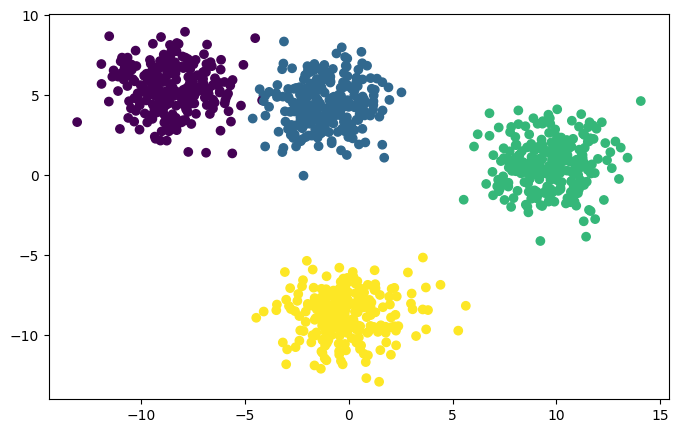

In [72]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Creating Model

In [73]:
class BlobClassifier(nn.Module):
    def __init__(self, in_features, out_features, units):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features=units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear_stack(x)

torch.manual_seed(SEED)
model = BlobClassifier(NUM_FEATURES, NUM_CLASSES, 8)
model.to(device)

model

BlobClassifier(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Loss Function and Optimizer

In [74]:
# Setting up a loss function
# Note: Add weights to classes using weight parameter for imbalanced datasets.
loss_fn = nn.CrossEntropyLoss() 

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Logits to Prediction Labels

What is the output of model?

- Last linear layer outputs logits.
- Total of 4 predictable classes available. 4 output will be calculated.
- As can be seen 4 outputs should be sent through a softmax function in order to turn into probability distribution.

`output -> softmax -> classification probabilities -> argmax -> predicted class`

Setting model to evaluation mode for observing model output.
- 4 logits outputted.

In [75]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_train.to(device))

y_logits

tensor([[-0.4339,  0.5038, -0.0338, -0.8939],
        [ 0.1394, -0.4081, -0.6073, -0.2584],
        [-0.1147,  0.2416, -0.3481, -0.1738],
        ...,
        [-0.3099,  0.2379, -0.4598, -0.1904],
        [ 0.5182, -0.3722, -0.8463, -0.3708],
        [ 0.1787, -0.4749, -0.7041, -0.3107]], device='cuda:0')

Sending outputs to softmax for calculating prediction probabilities.
- Sum of values in a row equals to 1 due to softmax.
- Each index of a row shows the likelihood of belonging to a class.

In [76]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred_probs

tensor([[0.1761, 0.4499, 0.2628, 0.1112],
        [0.3671, 0.2123, 0.1740, 0.2466],
        [0.2402, 0.3431, 0.1902, 0.2265],
        ...,
        [0.2120, 0.3666, 0.1825, 0.2389],
        [0.4815, 0.1976, 0.1230, 0.1979],
        [0.3927, 0.2043, 0.1624, 0.2407]], device='cuda:0')

With `torch.argmax()` we can get the index of class with the highest probability. 

In [77]:
pred_prob = torch.max(y_pred_probs[:1])
pred_class = torch.argmax(y_pred_probs[:1])

print(f"Predicted class {pred_class} with {pred_prob * 100:.2f} probability.")

Predicted class 1 with 44.99 probability.


## Metric for Training: Accuracy

In [78]:
# Calculating accuracy
# Formula: (True Positives + True Negatives) / (All Predictions) * 100

def calc_accuracy(y_true, y_pred):
    tp_tn = torch.eq(y_true, y_pred).sum().item()
    acc = (tp_tn / len(y_true)) * 100

    return acc

## Training

In [79]:
# from helper_functions import plot_decision_boundary

torch.manual_seed(7)
torch.cuda.manual_seed(7)

EPOCHS = 100
PAD = len(str(EPOCHS))


# Be sure that model and data in same device
model.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Train loop
for epoch in range(1, EPOCHS+1):
    # model.to(device)
    # Set model to train mode
    model.train()

    # Stop gradients accumulating
    optimizer.zero_grad()

    # Make predictions
    y_logits = model(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    
    # Calculate accuracy
    acc = calc_accuracy(y_train, y_preds)

    # Backpropagation
    loss.backward()

    # Adjust parameters
    optimizer.step()

    
    # Test loop
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.inference_mode():
        # Make test predictions
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Calculate test loss
        test_loss = loss_fn(test_logits, y_test)

        # Calculate test accuracy
        test_acc = calc_accuracy(y_test, test_preds)

        # plt.figure()
        # plt.title(f"Epoch {epoch}")
        # plot_decision_boundary(model, X_test, y_test)
        # plt.savefig(f"{epoch}.png")

        if epoch % 10 == 0:
            print(f"Epoch {epoch:>{PAD}} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch  10 | Loss: 0.77344 | Acc: 62.25 | Test Loss: 0.73814 | Test Acc: 62.50
Epoch  20 | Loss: 0.49740 | Acc: 73.00 | Test Loss: 0.48031 | Test Acc: 69.00
Epoch  30 | Loss: 0.26639 | Acc: 97.88 | Test Loss: 0.23555 | Test Acc: 98.00
Epoch  40 | Loss: 0.14336 | Acc: 98.12 | Test Loss: 0.12407 | Test Acc: 98.50
Epoch  50 | Loss: 0.10065 | Acc: 98.50 | Test Loss: 0.08993 | Test Acc: 98.50
Epoch  60 | Loss: 0.07968 | Acc: 98.75 | Test Loss: 0.07472 | Test Acc: 99.00
Epoch  70 | Loss: 0.06737 | Acc: 98.62 | Test Loss: 0.06658 | Test Acc: 99.00
Epoch  80 | Loss: 0.05931 | Acc: 98.88 | Test Loss: 0.06172 | Test Acc: 99.00
Epoch  90 | Loss: 0.05360 | Acc: 98.88 | Test Loss: 0.05856 | Test Acc: 99.00
Epoch 100 | Loss: 0.04933 | Acc: 98.88 | Test Loss: 0.05636 | Test Acc: 99.00


Data is almost linearly separable. Non-linearity can be removed if wanted. But it would not hurt to have it in the model. Model would be much more resilient to input data if dataset is not contains linearly separable data.

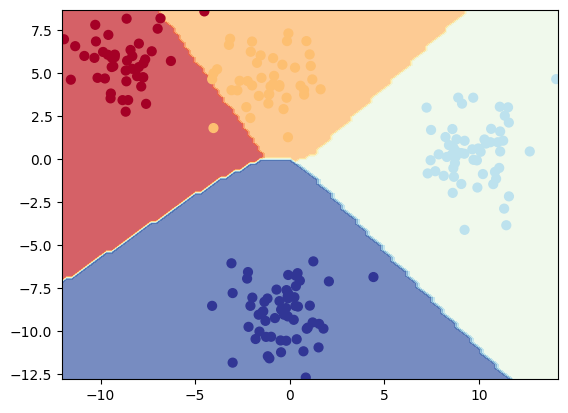

In [80]:
from helper_functions import plot_decision_boundary

plt.figure()
plot_decision_boundary(model, X_test, y_test)
plt.show()